# Наивный Байес и спам
__Суммарное количество баллов: 8__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][ML][MS][HW10] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import spacy
from nltk.stem.snowball import SnowballStemmer
from typing import NoReturn
from collections import Counter
from string import punctuation

In [ ]:
import re
def read_dataset(filename):
    file = open(filename, encoding="utf-8")
    x = []
    y = []
    for line in file:
        cl, sms = re.split("^(ham|spam)[\t\s]+(.*)$", line)[1:3]
        x.append(sms)
        y.append(cl)
    return np.array(x, dtype=np.str), np.array(y, dtype=np.str)

In [ ]:
def get_precision_recall_accuracy(y_pred, y_true):
    classes = np.unique(list(y_pred) + list(y_true))
    true_positive = dict((c, 0) for c in classes)
    true_negative = dict((c, 0) for c in classes)
    false_positive = dict((c, 0) for c in classes)
    false_negative = dict((c, 0) for c in classes)
    for c_pred, c_true in zip(y_pred, y_true):
        for c in classes:
            if c_true == c:
                if c_pred == c_true:
                    true_positive[c] = true_positive.get(c, 0) + 1
                else:
                    false_negative[c] = false_negative.get(c, 0) + 1
            else:
                if c_pred == c:
                    false_positive[c] = false_positive.get(c, 0) + 1
                else:
                    true_negative[c] = true_negative.get(c, 0) + 1
    precision = dict((c, true_positive[c] / (true_positive[c] + false_positive[c])) for c in classes)
    recall = dict((c, true_positive[c] / (true_positive[c] + false_negative[c])) for c in classes)
    accuracy = sum([true_positive[c] for c in classes]) / len(y_pred)
    return precision, recall, accuracy

def plot_precision_recall(X_train, y_train, X_test, y_test, bow_method, voc_sizes=range(4, 200, 5)):
    classes = np.unique(list(y_train) + list(y_test))
    precisions = dict([(c, []) for c in classes])
    recalls = dict([(c, []) for c in classes])
    accuracies = []
    for v in voc_sizes:
        bow = bow_method(X_train, voc_limit=v)
        X_train_transformed = bow.transform(X_train)
        X_test_transformed = bow.transform(X_test)
        classifier = NaiveBayes(0.001)
        classifier.fit(X_train_transformed, y_train)
        y_pred = classifier.predict(X_test_transformed)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in classes:
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("Vocabulary size")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(list(ys.values()))-0.01, np.max(list(ys.values()))+0.01)
        for c in ys.keys():
            plt.plot(x, ys[c], label="Class " + str(c))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(voc_sizes, recalls, "Recall")
    plot(voc_sizes, precisions, "Precision")
    plot(voc_sizes, {"":accuracies}, "Accuracy", legend=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
X, y = read_dataset("/content/drive/MyDrive/spam")

Mounted at /content/drive


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

### Задание 1 (3 балла)
Реализуйте классификацию методом Байеса в предположении независимости компонент `x`. При реализации следует считать, что значения каждой компоненты дискретны, а `p(x|y)` имеет мультиномиальное распределение.

#### Методы
`fit(X, y)` - оценивает параметры распределения `p(x|y)` для каждого `y`. 

`log_proba(X)` - для каждого элемента набора `X` считает логарифм вероятности отнести его к каждому классу. По теореме Байеса: `p(y|x) = p(y)p(x|y)/p(x)`. Соответственно, после логарифмирования: `log p(y|x) = log p(y) + log p(x|y) - log p(x)`. Поскольку `log p(x)` является независящей от класса `y` константой, это слагаемое никак не влияет на решение задачи максимизации. Поэтому его можно просто убрать для простоты.

In [ ]:
class NaiveBayes:
    def __init__(self, alpha: float):
        self.alpha = alpha
    
    def fit(self, X: np.ndarray, y: np.ndarray):
        self.classes, counts = np.unique(y, return_counts=True)
        self.prob_y = np.log(counts/X.shape[0])
        feat = X.shape[1]
        p_hat = np.zeros((self.classes.shape[0], feat))
        
        for i, label in enumerate(self.classes):
            X_class = X[y==label]
            div = np.sum(X_class)
            for j in range(feat):
                p_hat[i, j] = (np.sum(X_class[:,j]) + self.alpha) / (div + self.alpha * feat)
        
        self.log_p_hat = np.log(p_hat)
        
    def predict(self, X: np.ndarray):
        return [self.classes[i] for i in np.argmax(self.log_proba(X), axis=1)]
    
    def log_proba(self, X: np.ndarray) -> np.ndarray:
        n_classes = self.classes.shape[0]
        matrix = np.zeros((X.shape[0], n_classes))
        
        for i, elem in enumerate(X):
            for j in range(n_classes):
                matrix[i, j] = np.sum(self.log_p_hat[j] * elem) + self.prob_y[j]
          
        return matrix


### Задание 2 (3 балла)
Теперь реализуем метод bag of words. Задача состоит в том, чтобы посчитать количество вхождений каждого слова в предложение.

#### Методы
`__init__(X, voc_limit)` - инициализирует BoW, составляя словарь, который будет использоваться для векторизации предложений. Размер словаря должен быть не больше `voc_limit`, в него должны входить самые часто встречающиеся в выборке слова.

`transform(X)` - векторизует сообщения из набора.

In [39]:
class BoW:
    def __init__(self, X: np.ndarray, voc_limit: int = 1000):

        self.voc_limit = voc_limit
        sentences = []
        for sentence in X:
            sentences.extend(self.processing(sentence.lower()))

        vocab, word_freq = np.unique(np.asarray(sentences), return_counts=True)
        freqs = (word_freq).argsort()[::-1]
        self.vocab = vocab[freqs][:self.voc_limit]
        self.codes = {word: k for k, word in enumerate(self.vocab)}


    def processing(self, sentence):
        return re.sub(r'[.,!?\'\"()]', '', sentence).split()



    def transform(self, X: np.ndarray) -> np.ndarray:

        n_sentences = X.shape[0]
        X_vector = np.zeros((n_sentences, self.voc_limit), dtype=int)

        for i, sentence in enumerate(X):
            sentence = self.processing(sentence)
            row = np.zeros(self.voc_limit, dtype=int)
            for word in sentence:
                if word in self.codes.keys():
                    idx = self.codes[word]
                    row[idx] += 1
            X_vector[i, :] = row.copy()
        return X_vector

In [37]:
bow = BoW(X_train, voc_limit=500)
X_train_bow = bow.transform(X_train)
X_test_bow = bow.transform(X_test)

In [38]:
predictor = NaiveBayes(0.001)
predictor.fit(X_train_bow, y_train)
get_precision_recall_accuracy(predictor.predict(X_test_bow), y_test)

({'ham': 0.9878048780487805, 'spam': 0.8787878787878788},
 {'ham': 0.9838056680161943, 'spam': 0.90625},
 0.974910394265233)

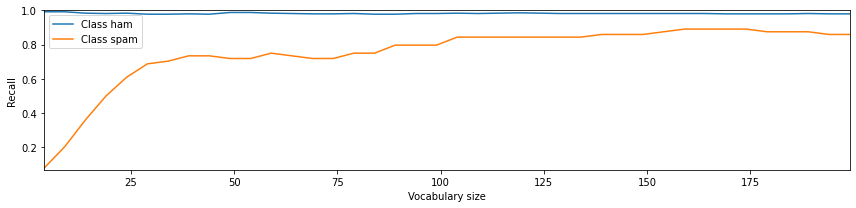

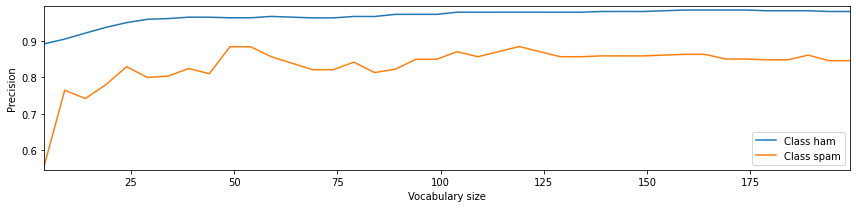

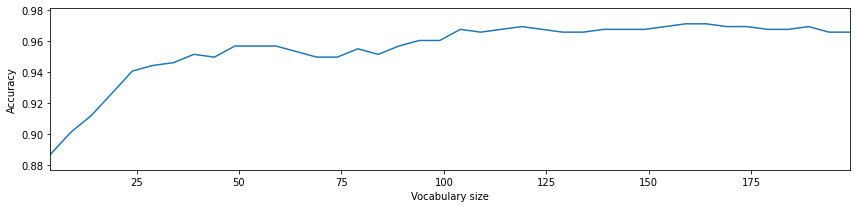

In [ ]:
plot_precision_recall(X_train, y_train, X_test, y_test, BoW)

### Задание 3 (2 балла)
Теперь добавим в BoW стемминг. Для этого нам понадобится класс SnowballStemmer из пакета `nltk`

#### Методы
`__init__(X, voc_limit)` - инициализирует BoW, составляя словарь, который будет использоваться для векторизации предложений. Размер словаря должен быть не больше `voc_limit`, в него должны входить самые часто встречающиеся в выборке слова.

`transform(X)` - векторизует сообщения из набора.

In [49]:
class BowStem:
    def __init__(self, X: np.ndarray, voc_limit: int = 1000):

        self.voc_limit = voc_limit
        sentences = []
        for sentence in X:
            sentences.extend(self.processing(sentence.lower()))

        vocab, word_freq = np.unique(np.asarray(sentences), return_counts=True)
        freqs = (word_freq).argsort()[::-1]
        self.vocab = vocab[freqs][:self.voc_limit]
        self.codes = {word: k for k, word in enumerate(self.vocab)}

        
    def processing(self, sentence):
        words = re.sub(r'[.,!?\'\"()]', '', sentence).split()
        result = []
        snow_stemmer = SnowballStemmer(language='english') 

        for word in words:
            result.append(snow_stemmer.stem(word))

        return result
        


    def transform(self, X: np.ndarray) -> np.ndarray:
        n_sentences = X.shape[0]
        X_vector = np.zeros((n_sentences, self.voc_limit), dtype=int)

        for i, sentence in enumerate(X):
            sentence = self.processing(sentence)
            row = np.zeros(self.voc_limit, dtype=int)
            for word in sentence:
                if word in self.codes.keys():
                    idx = self.codes[word]
                    row[idx] += 1
            X_vector[i, :] = row.copy()
        return X_vector

In [50]:
bows = BowStem(X_train, voc_limit=500)
X_train_bows = bows.transform(X_train)
X_test_bows = bows.transform(X_test)

In [51]:
predictor = NaiveBayes(0.001)
predictor.fit(X_train_bows, y_train)
get_precision_recall_accuracy(predictor.predict(X_test_bows), y_test)

({'ham': 0.9838383838383838, 'spam': 0.8888888888888888},
 {'ham': 0.9858299595141701, 'spam': 0.875},
 0.9731182795698925)

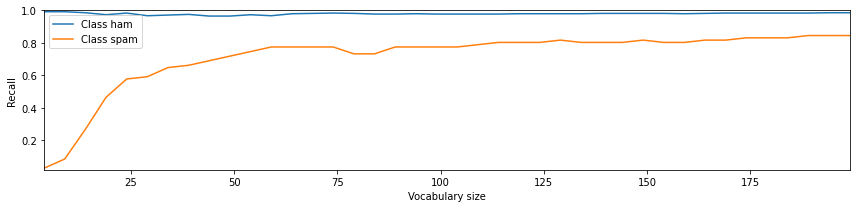

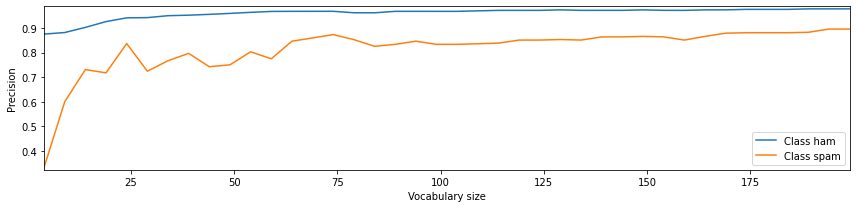

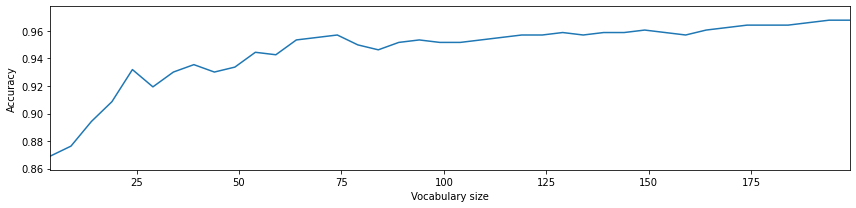

In [ ]:
plot_precision_recall(X_train, y_train, X_test, y_test, BowStem)